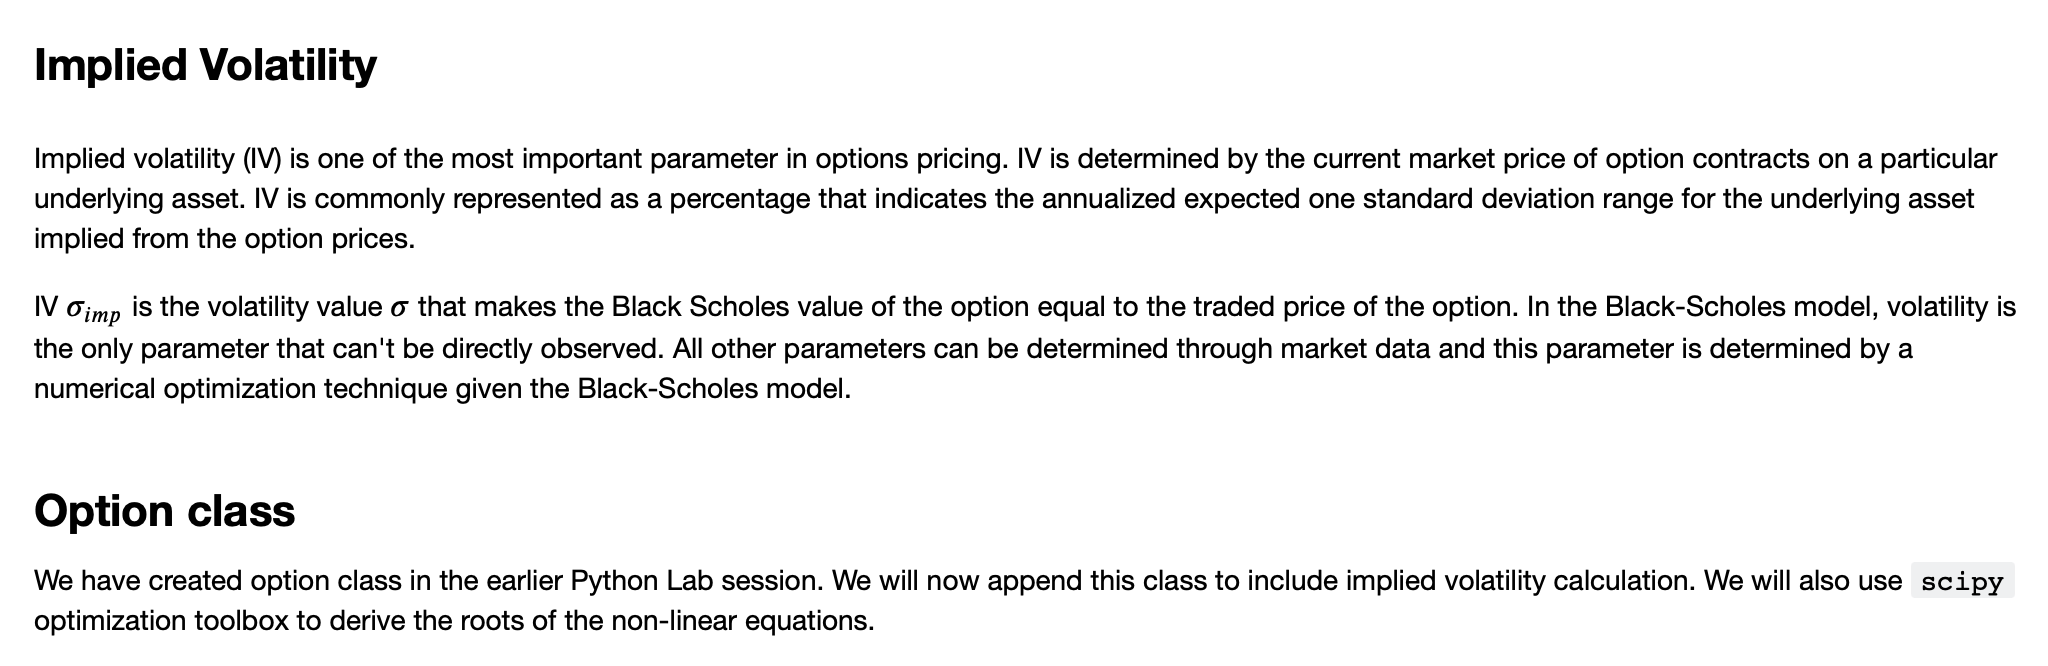

In [2]:
# Data Manipulation
import pandas as pd
from numpy import *
import yfinance as yf
from datetime import date, timedelta

# Import BlackScholes
from utilities.blackscholes import BS

# Plotting
import cufflinks as cf
cf.set_config_file(offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

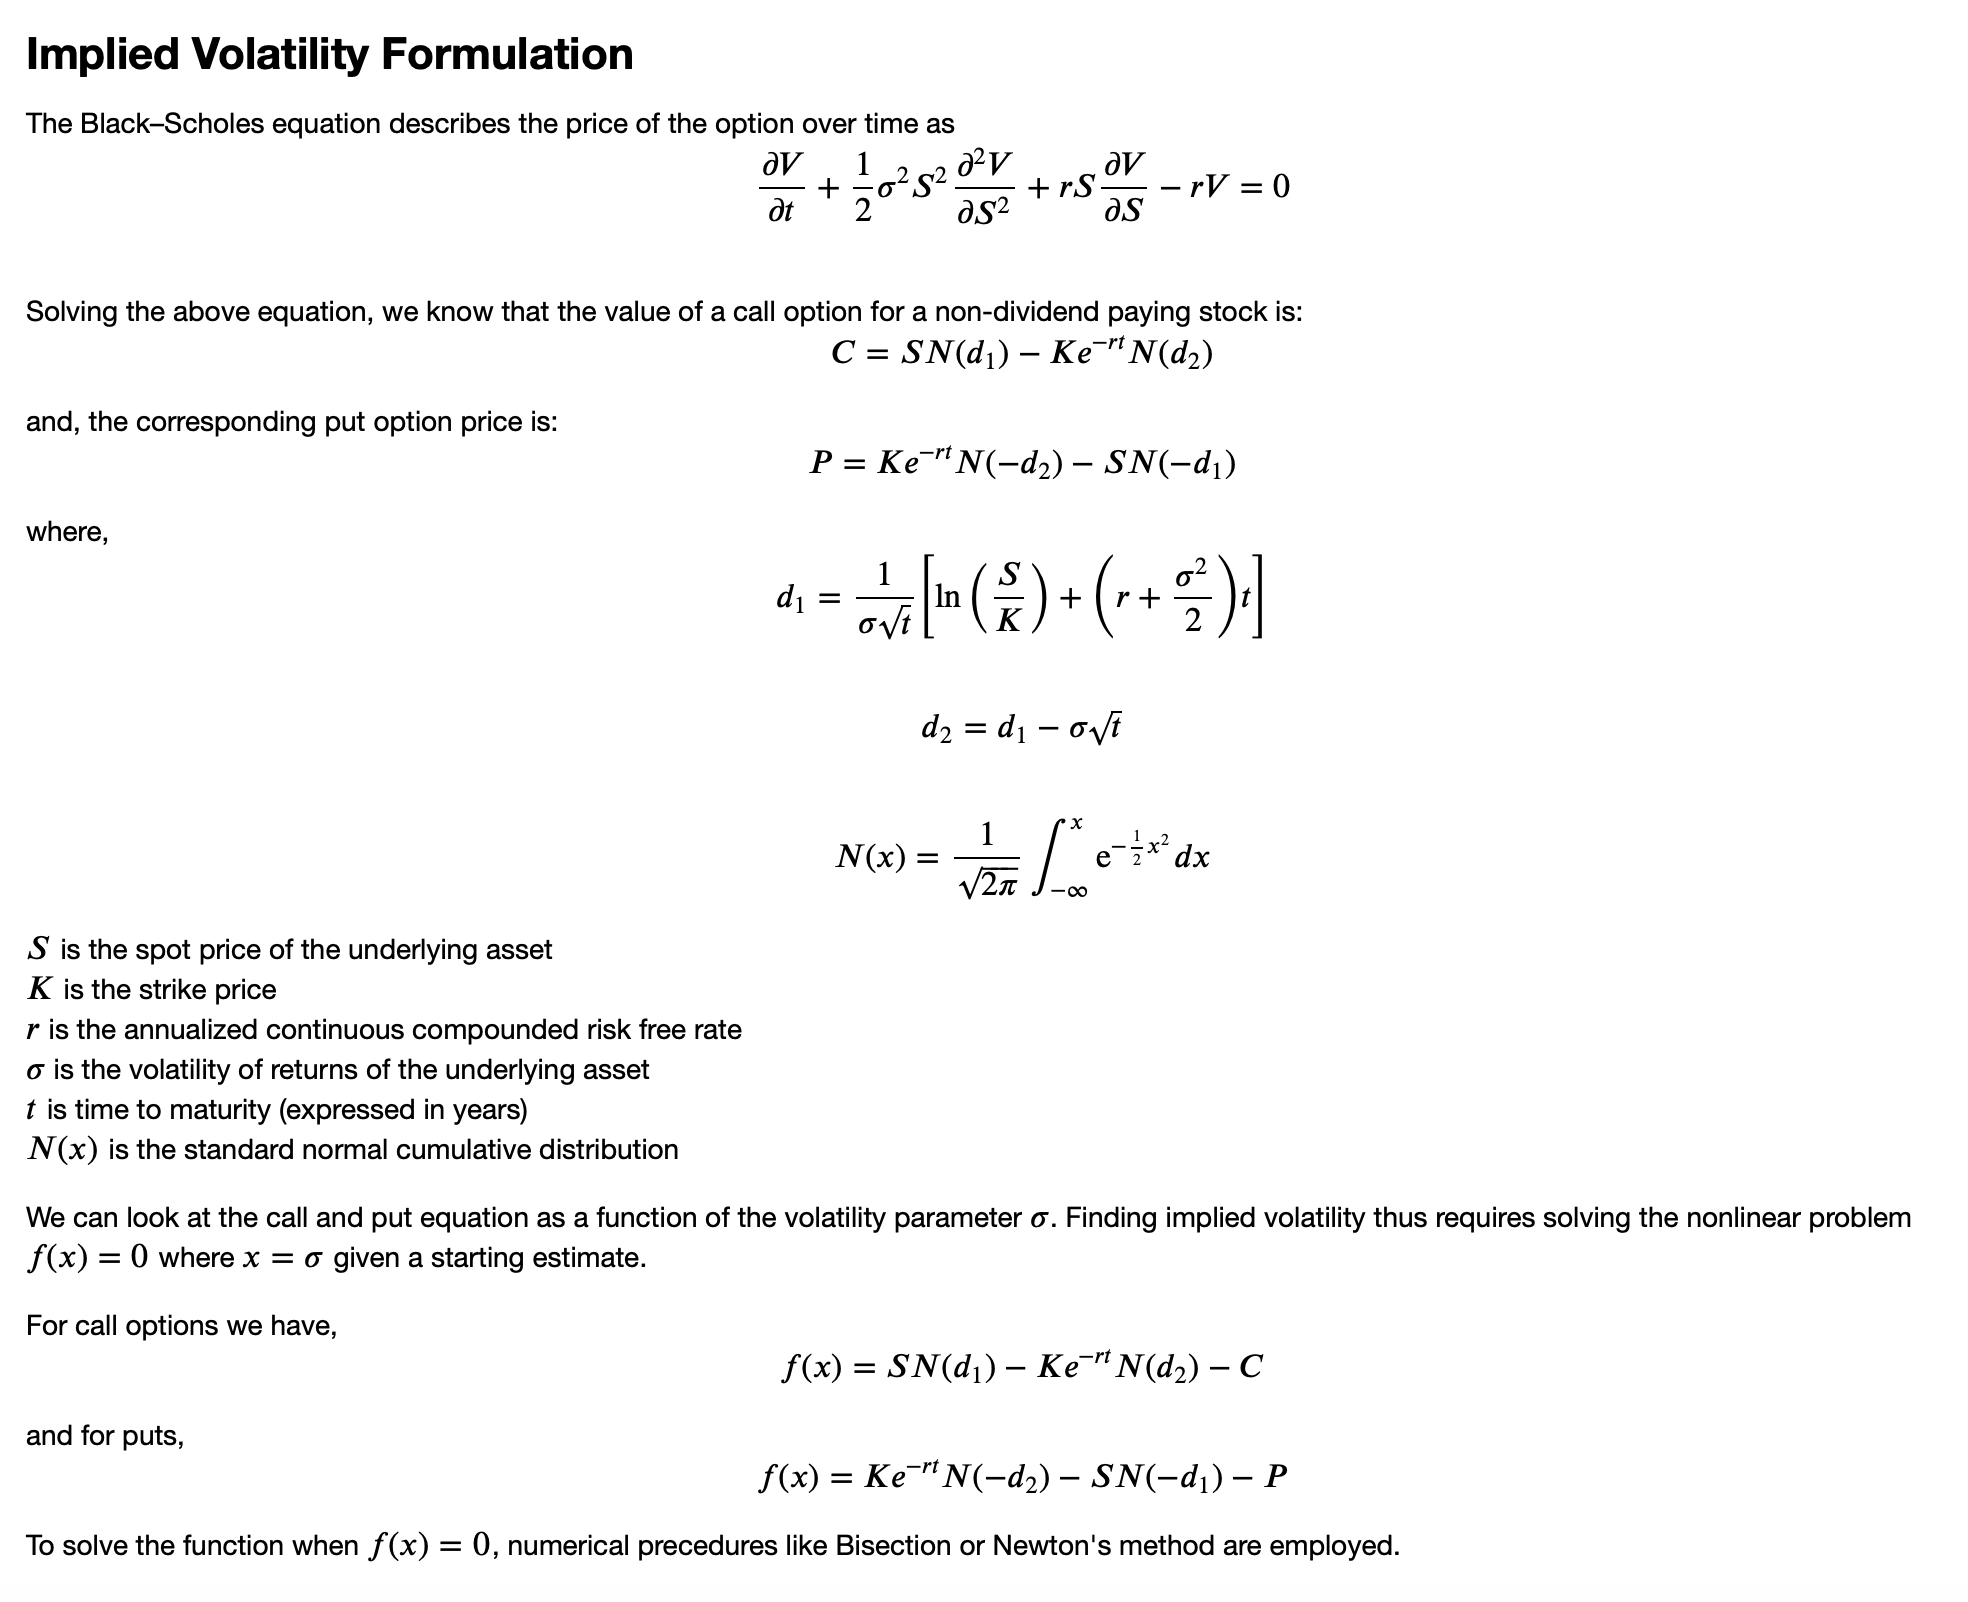

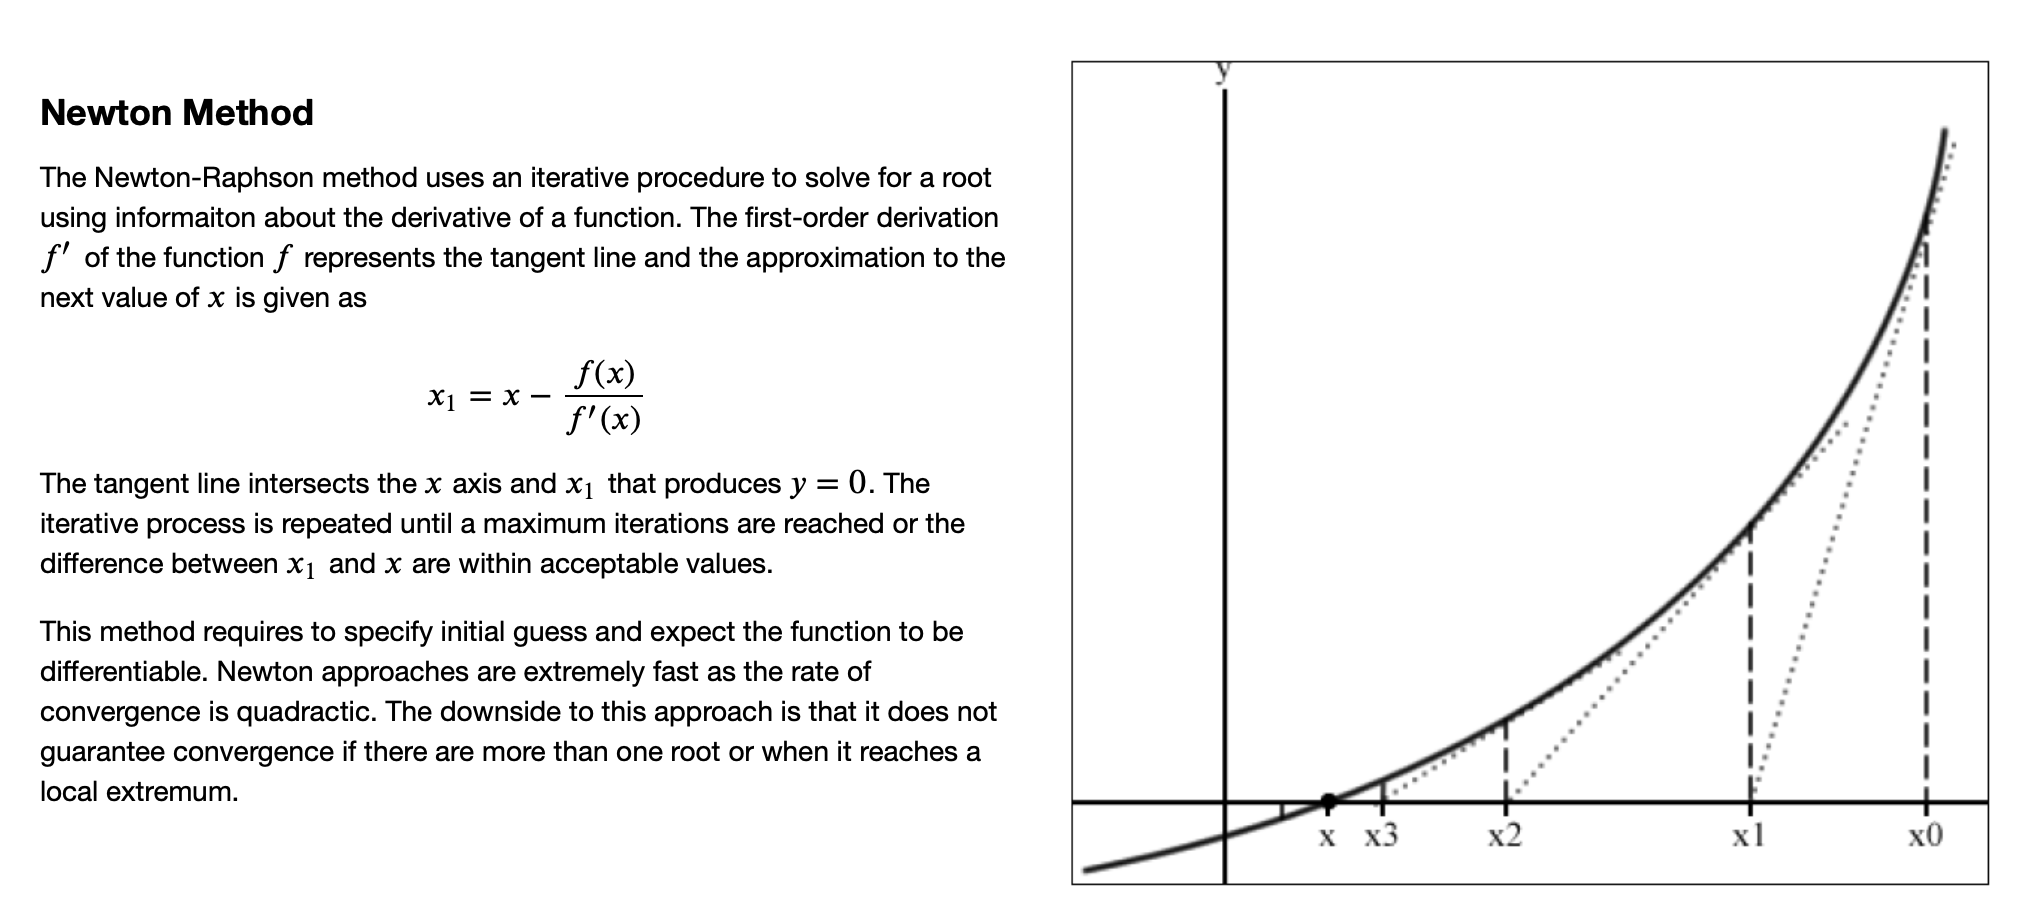

In [3]:
def newton_iv(className, spot, strike, rate, dte, volatility, callprice=None, putprice=None):
    
    x0 = 1 # initial guess
    h = 0.001
    tolerance = 1e-7
    epsilon = 1e-14                             # some kind of error or floor
    
    maxiter = 200
    
    if callprice:
        # f(x) = Black Scholes Call price - Market Price - defining the f(x) here
        f = lambda x: eval(className)(spot, strike, rate, dte, x).callPrice - callprice
    if putprice:
        f = lambda x: eval(className)(spot, strike, rate, dte, x).putPrice - putprice
        
    for i in range(maxiter):
        y = f(x0)
        yprime = (f(x0+h) - f(x0-h))/(2*h)      # central difference
        
        if abs(yprime)<epsilon:
            break                               # this is critial, because volatility cannot be negative
        x1 = x0 - y/yprime
        
        if (abs(x1-x0) <= tolerance*abs(x1)):
            break
        x0=x1
        
    return x1
        

In [4]:
# newton iv
newton_iv('BS',100,100,0.02,1,0.2,callprice=8)

0.17657213831399154

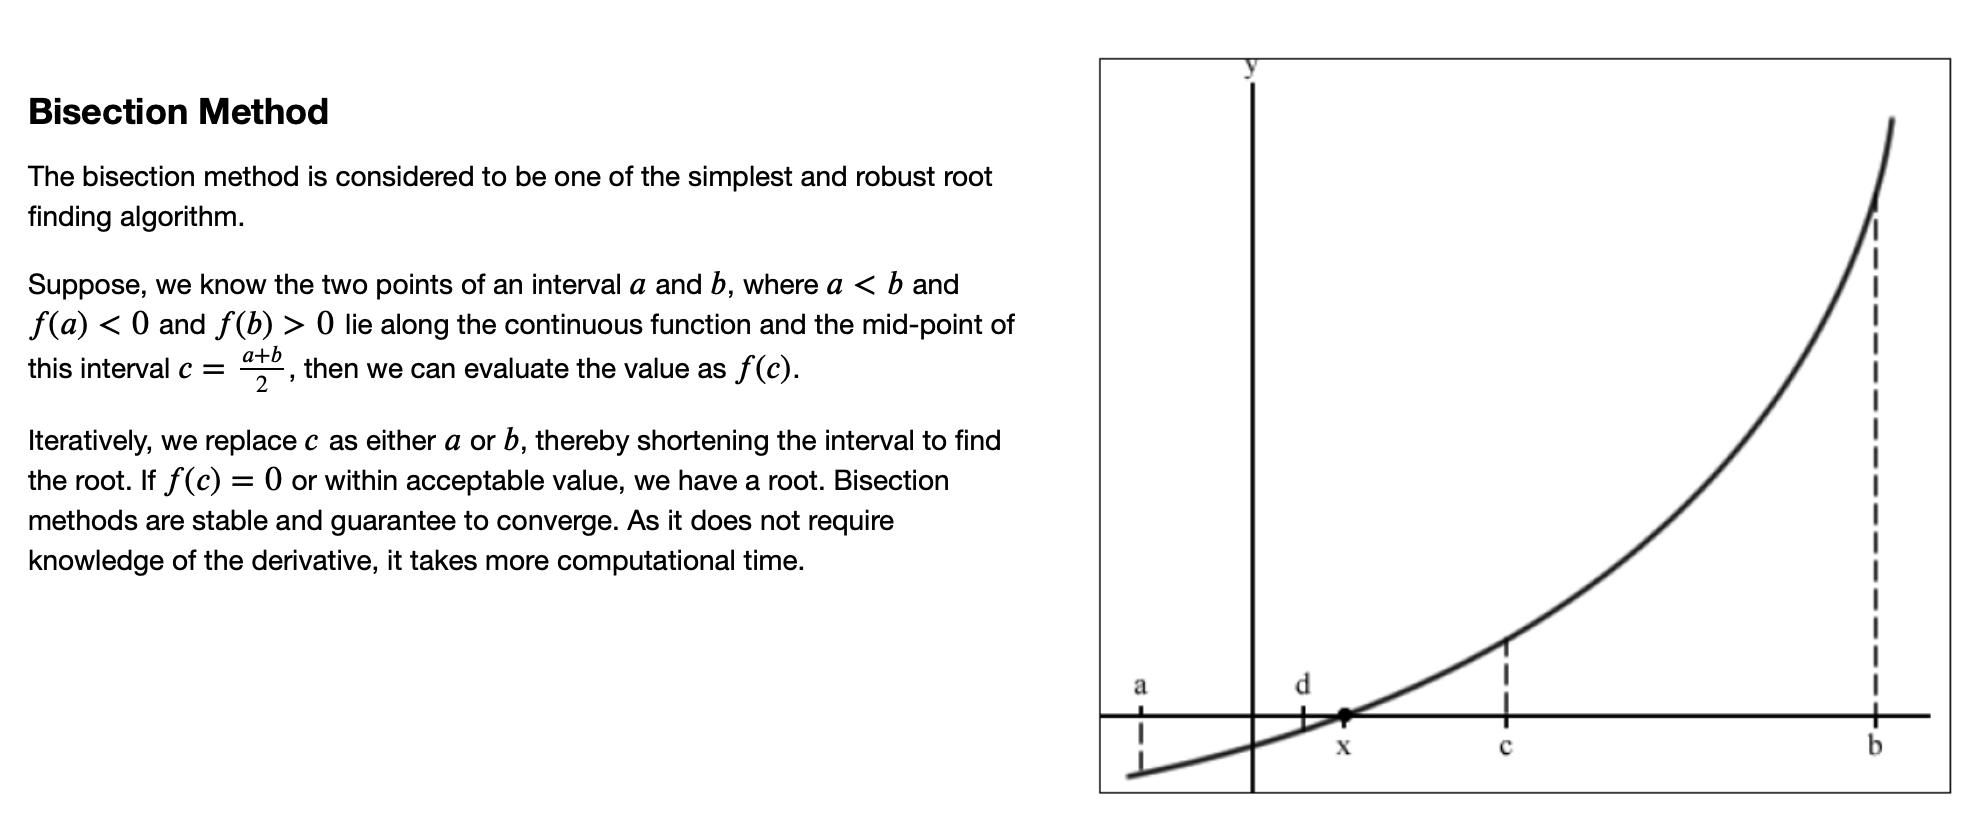

In [5]:
# Bisection Method
def bisection_iv(className, spot, strike, rate, dte, volatility, callprice=None, putprice=None, high=500.0, low=0.0):
    
    # this is market price
    if callprice:
        price = callprice
    if putprice and not callprice:
        price = putprice
        
    tolerance = 1e-7
        
    for i in range(1000):
        mid = (high + low) / 2 # c= (a+b)/2
        if mid < tolerance:
            mid = tolerance
            
        if callprice:
            estimate = eval(className)(spot, strike, rate, dte, mid).callPrice # Blackscholes price
        if putprice:
            estimate = eval(className)(spot, strike, rate, dte, mid).putPrice
        
        if round(estimate,6) == price:
            break
        elif estimate > price: 
            high = mid # b = c
        elif estimate < price: 
            low = mid # a = c
    
    return mid

## SPX Option
Let's now retrieve SPX option price from Yahoo Finance using yfinance library and manipulated the dataframe using the above Black Scholes option pricing model that we created.

In [6]:
# Create a ticker object
spx = yf.Ticker('^SPX')

In [7]:
# Get Expiry dates 
expiry_dates = sorted(spx.options)
expiry_dates[:15]

['2023-02-21',
 '2023-02-22',
 '2023-02-23',
 '2023-02-24',
 '2023-02-27',
 '2023-02-28',
 '2023-03-01',
 '2023-03-02',
 '2023-03-03',
 '2023-03-06',
 '2023-03-07',
 '2023-03-08',
 '2023-03-09',
 '2023-03-10',
 '2023-03-13']

In [8]:
# retrieve from yahoo finance
spx_call = spx.option_chain().calls
spx_puts = spx.option_chain().puts

# save locally
# spx_call.to_csv('data/spx_call.csv')
# spx_puts.to_csv('data/spx_puts.csv')

In [23]:
# Filter call option for Feb 2023 Expiry
jun = spx.option_chain('2023-06-16')

# Filter calls for strike above 4535
jun = jun.calls[jun.calls['strike']>4535]
jun.set_index('strike', inplace=True)

# Check the filtered output
jun.iloc[:,:11].head()

,contractSymbol,lastTradeDate,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney
strike,,,,,,,,,,,
4550.0,SPX230616C04550000,2023-02-17 19:10:35+00:00,18.10,19.1,19.8,-4.150000,-18.651684,146.0,9405,0.155381,False
4575.0,SPXW230616C04575000,2023-02-17 17:52:45+00:00,14.40,16.4,17.1,-4.700001,-24.607334,47.0,290,0.154603,False
4580.0,SPX230616C04580000,2023-02-17 16:51:52+00:00,14.15,15.6,16.3,-5.250000,-27.061855,3.0,1365,0.153718,False
4600.0,SPXW230616C04600000,2023-02-14 15:11:37+00:00,25.30,13.8,14.5,0.000000,0.000000,25.0,940,0.153283,False
4620.0,SPX230616C04620000,2023-02-13 19:10:04+00:00,22.33,11.9,12.6,0.000000,0.000000,7.0,165,0.152089,False


In [24]:
jun.shape

(45, 13)

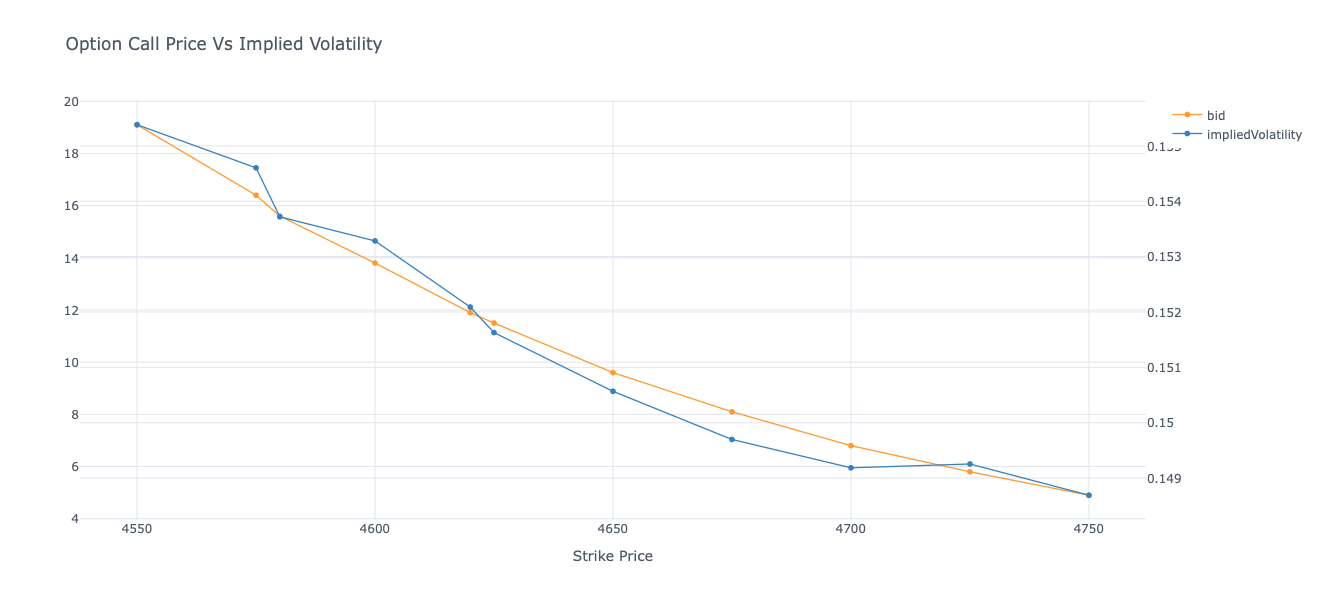

In [25]:
jun[['bid', 'impliedVolatility']][:4750].iplot(secondary_y='impliedVolatility', mode='lines+markers', size=6, 
                                              xTitle='Strike Price', title='Option Call Price Vs Implied Volatility')

In [28]:
spx.option_chain('2023-06-6')

ValueError: Expiration `2023-06-6` cannot be found. Available expiration are: [2023-02-21, 2023-02-22, 2023-02-23, 2023-02-24, 2023-02-27, 2023-02-28, 2023-03-01, 2023-03-02, 2023-03-03, 2023-03-06, 2023-03-07, 2023-03-08, 2023-03-09, 2023-03-10, 2023-03-13, 2023-03-14, 2023-03-15, 2023-03-16, 2023-03-17, 2023-03-20, 2023-03-21, 2023-03-22, 2023-03-24, 2023-03-31, 2023-04-14, 2023-04-21, 2023-04-28, 2023-05-19, 2023-05-31, 2023-06-16, 2023-06-30, 2023-07-21, 2023-07-31, 2023-08-18, 2023-09-15, 2023-09-29, 2023-10-20, 2023-11-17, 2023-12-15, 2023-12-29, 2024-01-19, 2024-02-16, 2024-03-15, 2024-06-21, 2024-12-20, 2025-12-19, 2026-03-20, 2026-12-18, 2027-12-17]

In [35]:
def ivskew(spot, rate, value_date, expiry, dataframe):
    
    dte = (pd.Timestamp(expiry)-pd.Timestamp(value_date))/timedelta(365)
    
    df = dataframe[['bid', 'ask']]
    df['mid'] = 0.5 * (df['bid']+df['ask'])
    df['strike'] = df.index
    df['IV'] = 0.

    for i in range(len(df)):
        df['IV'].iloc[i] = 100*BS(spot, 
                                df.strike.iloc[i], 
                                rate, dte, 0.2, 
                                callprice = df.mid.iloc[i]).impvol

    return df['IV']

In [36]:
# call the iv skew function
ivskew(4535, 0.007,'2023-04-14', '2023-06-30', jun)

TypeError: BS.__init__() got an unexpected keyword argument 'callprice'